# I. AdaBoost From Scratch


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?


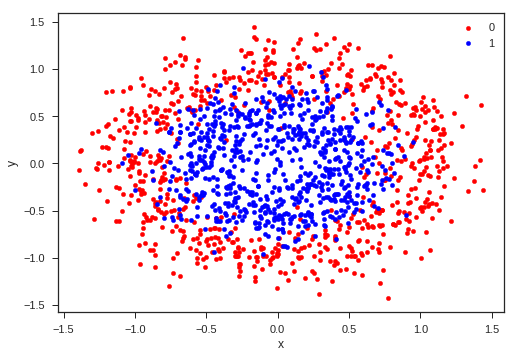

In [91]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [0]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

class Adaboost:

    def __init__(self, weak_learner_factory, n):
        self.weak_learner_factory = weak_learner_factory
        self.n = n
        self.alphas = []
        self.models = []


    def fit(self, X, y):
        y = np.where(y == 0, -1, 1)
        n = len(y)
        weights = np.ones(n) / (n * 1.0)

        for t in range(self.n):
            output = np.random.choice(n, n, p=weights)
            X_t = X[output]
            y_t = y[output]


            wl = self.weak_learner_factory()

            wl.fit(X_t, y_t)

            y_tag_t = wl.predict(X)
            
            error_t = np.sum((y_tag_t != y) * weights)
            
            alpha_t = 0.5 * np.log((1 - error_t) / error_t)
            
            self.alphas.append(alpha_t)
            weights = weights * np.exp(-alpha_t *  y *  y_tag_t)
            weights = weights / np.sum(weights)
            self.models.append(wl)



    def predict(self, X):

        all_sums = np.zeros(len(X))

        for index, wl in enumerate(self.models):
            prediciotn = self.alphas[index] * wl.predict(X)
            all_sums += prediciotn

        return np.where(all_sums > 0, 1, 0)
    
    def decision_function(self, X):
        all_sums = np.zeros(len(X))

        for index, wl in enumerate(self.models):
            prediciotn = self.alphas[index] * wl.predict(X)
            all_sums += prediciotn
        
        return all_sums




      

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                        random_state=999)

model = Adaboost(lambda : LinearSVC(random_state=999),1000)

model.fit(X_train, y_train)
y_test_tag = model.predict(X_test)
print(np.sum(y_test_tag == y_test) / (len(y_test) * 1.0))

0.8833333333333333


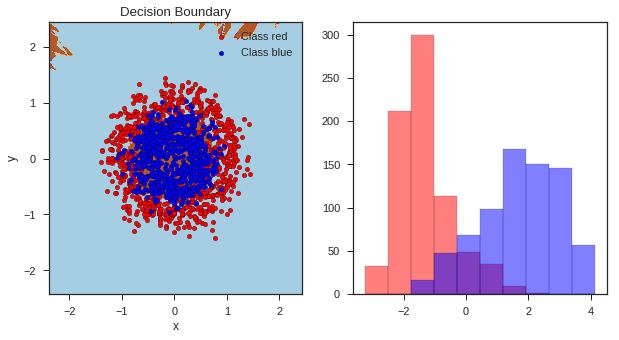

In [94]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

plot_colors = ["r", "b"]
plot_step = 0.02
class_names = ['red' ,'blue']

plt.figure(figsize=(10, 5))
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")


for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')   

twoclass_output = model.decision_function(X)
(twoclass_output.shape, X.shape, twoclass_output[1])

plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')

# II. Boosting Trees from Scratch
* Use the scikit-learn's DecisionTreeRegressor with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* **Optional**: add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [0]:

from sklearn.tree import DecisionTreeRegressor
import numpy as np

class SimpleModel:

    def __init__(self, prev_model, mu):
        self.prev_model = prev_model
        self.mu = mu
        self.mode=  None

    def fit(self, X, y):
        target = y - self.prev_model.predict(X)
        self.model = DecisionTreeRegressor(max_depth=1)
        self.model.fit(X, target)

    def predict(self, X):
        return self.prev_model.predict(X) + self.mu * self.model.predict(X)


class MeanModel:

    def __init__(self):
        self.mode=  None

    def fit(self, X, y):
        mean = np.mean(X)

        self.model = lambda x: np.repeat(mean, len(x))

    def predict(self, X):
        return self.model(X)



class L2Boost:

    def __init__(self, M, mu):
        self.M = M
        self.mu = mu
        self.model = None

    def fit(self, X, y):

        self.model = MeanModel()
        self.model.fit(X, y)

        for i in range(self.M):
            current = SimpleModel(self.model, self.mu)
            current.fit(X, y)
            self.model = current

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        predicions = self.predict(X)
        mse = np.mean(np.square(y - predicions))

        return mse



In [0]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import sys
sys.setrecursionlimit(1500)

X, y = load_boston(return_X_y=True)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=999)

In [97]:
model = L2Boost(1000, 0.01)
model.fit(X_train, y_train)
model.score(X_test, y_test)

13.664523748661335

In [0]:
lrs = [0.001]
n_trees = range(100, 1000, 100)

tree_size_score = {'tree_size': [], 'score':[]}
for lr in lrs:
  for n_tree in n_trees:
    n_tree = int(n_tree)
    tree_size_score['tree_size'].append(n_tree)
    
    model = L2Boost(n_tree, lr)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    tree_size_score['score'].append(score)
    

Text(1.0060000000000002, 0.5, 'score')

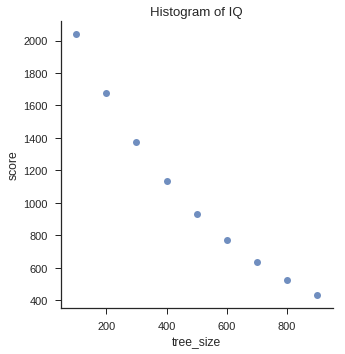

In [99]:
import pandas as pd
import seaborn as sns
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(tree_size_score)

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

sns.lmplot('tree_size', 'score',  data=df,  fit_reg=False)

plt.title('Histogram of IQ')

plt.xlabel('tree_size')

plt.ylabel('score')
